# HBR transfer example

Welcome to this example/tutorial notebook that will go through the fitting, evaluation, transfering, and extending of HBR models. 

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.prior import make_prior
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.regression_model.hbr.likelihood import *
import arviz as az

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)
data = pd.read_csv("resources/data/fcon1000.csv")
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
# response_vars = ["rh_MeanThickness_thickness"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects({"site": transfer_sites}, names=("transfer", "fit"))

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. 

Our `NormConf` object configures:
- a save path paths and whether to save the model and results
- a standardization step for both the covariates (inscaler) and the response vars (outscaler)
- a Bspline basis expansion of order 3 with 5 knots

## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a Normal likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. We also use the mapping_params to scale the mapping by a factor of 3, to avoid spikes in the resulting density. 

In [3]:
save_dir = "resources/hbr/save_dir"
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir=save_dir,
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

# Complex mu sigma
mu = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(
        random=True,
        mu=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
        sigma=make_prior(dist_name="HalfCauchy", dist_params=(0.5,)),
    ),
)
sigma = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)
# complex epsilon delta
epsilon = make_prior(
    dist_name="Normal",
    dist_params=(0.0, 1.0),
)
delta = make_prior(
    dist_name="Normal",
    dist_params=(1.0, 2.0),
    mapping="softplus",
    mapping_params=(0.0, 3.0, 0.6),
)

# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    pymc_cores=16,
    likelihood=SHASHbLikelihood(mu, sigma, epsilon, delta),
    nuts_sampler="nutpie",
)

Process: 8071 - Configuration of normative model is valid.


## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [4]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [5]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

# Fit the model

In [6]:
predictions = norm_hbr.fit_predict(train, test)


Process: 8071 - Fitting and predicting 2 response variables.
Process: 8071 - Fitting and predicting model for rh_MeanThickness_thickness.


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.00,1023
,2000,0,0.00,1023
,2000,1,0.02,511
,2000,0,0.00,1023


Sampling: [y_pred]


Output()

Process: 8071 - Fitting and predicting model for WM-hypointensities.


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.01,1023
,2000,0,0.02,1023
,2000,0,0.00,1023
,2000,0,0.01,1023


Sampling: [y_pred]


Output()

Process: 8071 - Saving model to resources/hbr/save_dir.
Process: 8071 - Computing log-probabilities for 2 response variables.
Process: 8071 - Computing log-probabilities for WM-hypointensities.
Process: 8071 - Computing log-probabilities for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8071 - Computing z-scores for 2 response variables.
Process: 8071 - Computing z-scores for WM-hypointensities.


Sampling: [y_pred]


Process: 8071 - Computing z-scores for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8071 - Computing centiles for 2 response variables.
Process: 8071 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


Process: 8071 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8071 - Saving results to resources/hbr/save_dir.
Process: 8071 - Computing centiles for 2 response variables.
Process: 8071 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


Process: 8071 - Computing centiles for rh_MeanThickness_thickness.


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)
/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

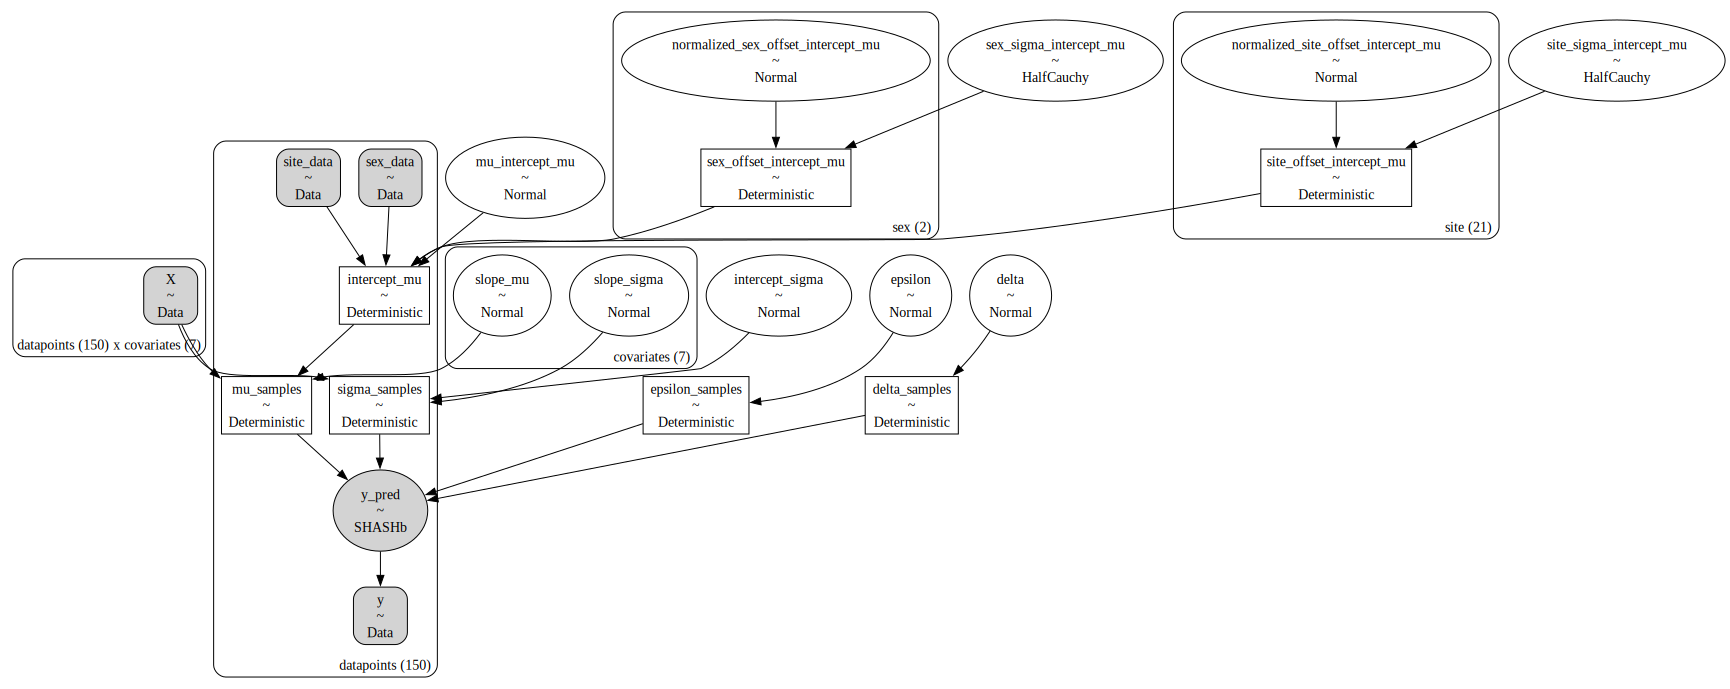

In [7]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.pymc_model.to_graphviz()  # type: ignore

We can use the arviz library to inspect the posterior samples (trace) of the model. Here we only use the 'plot_trace' function to inspect the trace of the model, but there are many other useful functions available. If you are not familiar with arviz, we recommend checking out the [arviz documentation](https://arviz-devs.github.io/arviz/index.html).


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['scaled_site_offset_intercept_mu', 'scaled_sex_offset_intercept_mu'] have not been found and will be ignored
  warnings.warn(


<Figure size 640x480 with 0 Axes>

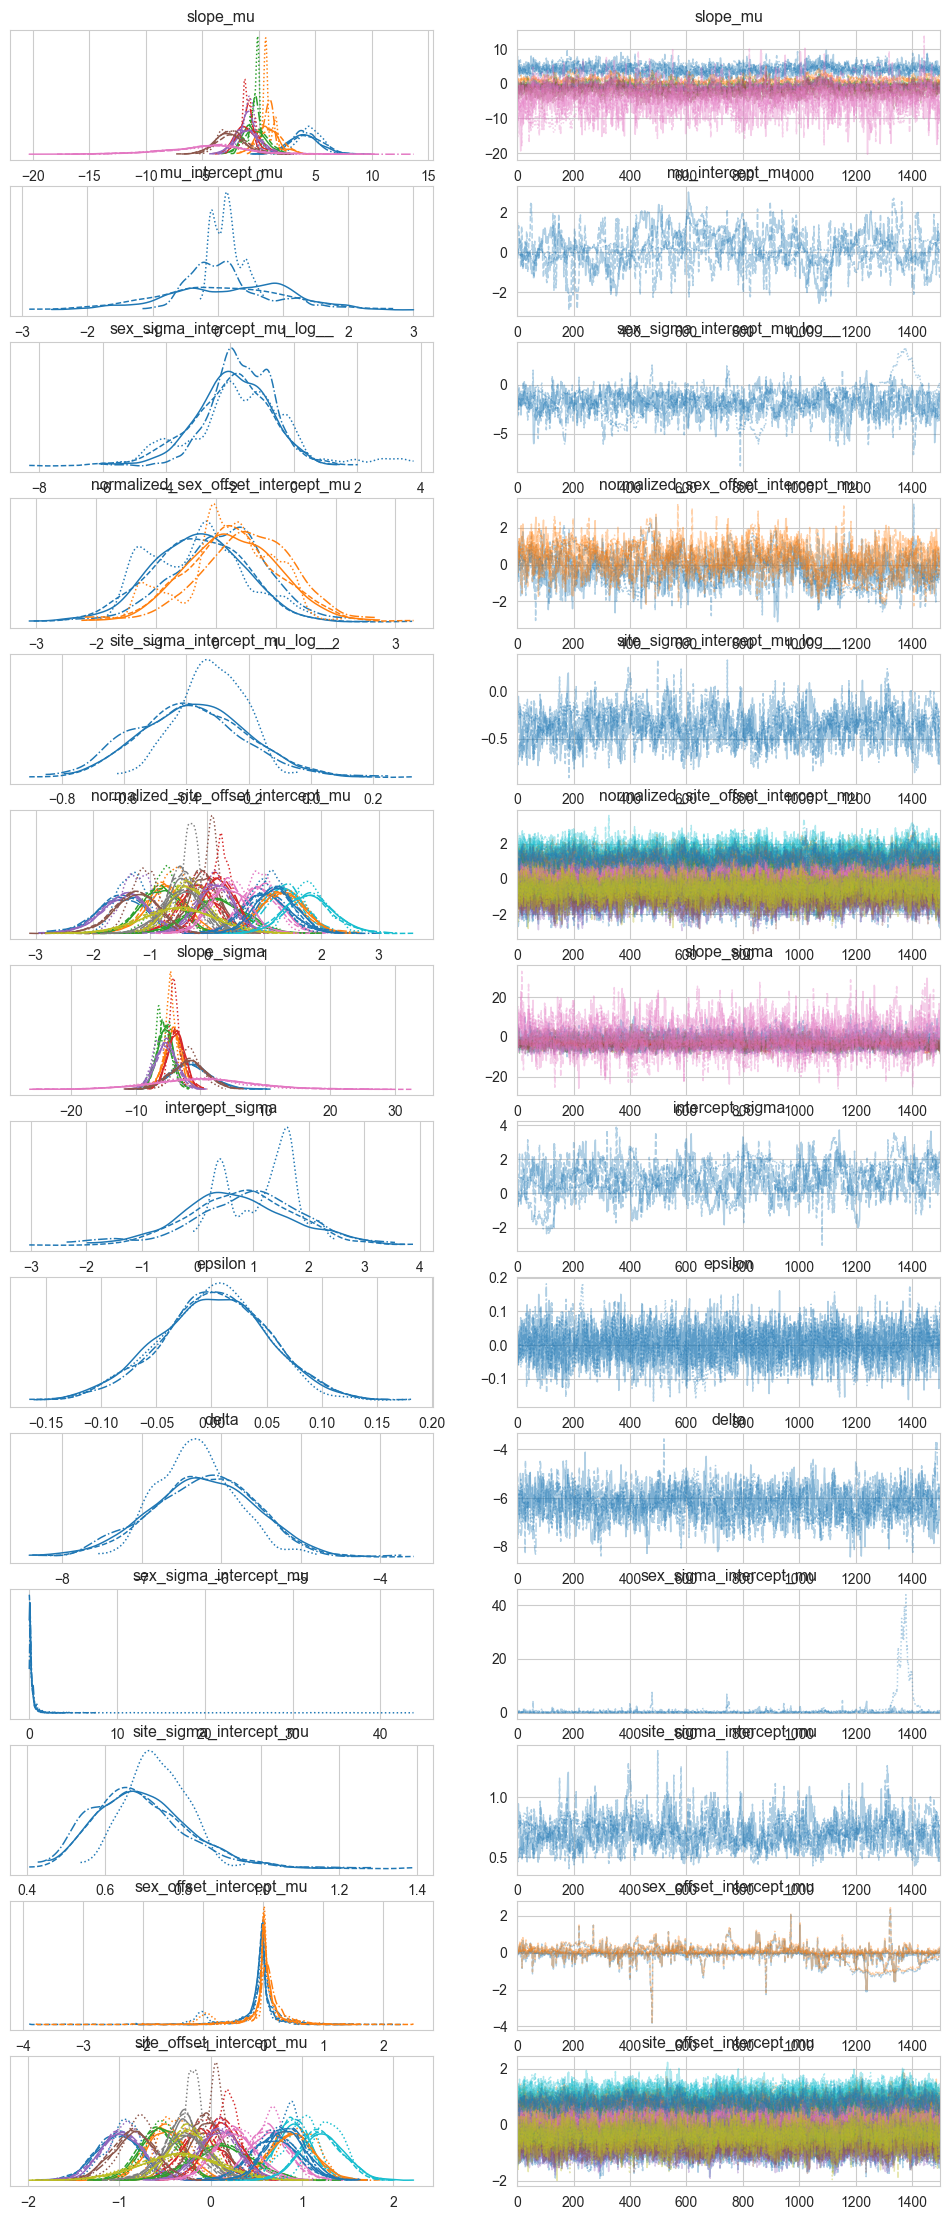

In [8]:
idata = model.idata  # type: ignore

plt.tight_layout()
az.plot_trace(
    idata.posterior,
    var_names=[
        "~mu_samples",
        "~sigma_samples",
        "~epsilon_samples",
        "~delta_samples",
        "~intercept_mu",
        "~scaled_site_offset_intercept_mu",
        "~scaled_sex_offset_intercept_mu",
    ],
)
plt.show()

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [9]:
display(test.measures.to_pandas().T)

response_vars,rh_MeanThickness_thickness,WM-hypointensities
measure,,
MSLL,-2.110972e+00,7.156492e+00
NLL,1.170746e+00,7.710266e-01
R2,3.531163e-01,4.447680e-01
RMSE,7.601868e-02,5.239267e+02
Rho,5.610987e-01,5.656253e-01
Rho_p,8.096636e-17,4.040154e-17
SMSE,3.607480e+01,2.007877e-07
ShapiroW,9.898166e-01,9.921713e-01


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [10]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
515,-0.672533,-0.352004
441,-0.297497,-0.413183
1029,1.315247,0.751119
64,-1.923527,0.366545
654,0.656748,-1.276422
...,...,...
611,-1.493484,2.056950
549,-1.564303,1.795809
640,-0.504120,-1.218797


In [11]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
515                             2.382919         837.976374   
441                             2.374637         929.559302   
1029                            2.480902         559.430256   
64                              2.314404         561.050440   
654                             2.350119         424.195719   
...                                  ...                ...   
611                             2.358917         500.967438   
549                             2.234896         574.802986   
640                             2.301424         448.131857   
648                             2.373265         545.558609   
635                             2.487519         448.796350   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
515                             2.456062        1033.989752   
441                             2.444596        1114.984942   
1029                            2.547648         734.878507   
64                              2.381385         735.891468   
654                             2.426703         755.842180   
...                                  ...                ...   
611                             2.436288         826.219775   
549                             2.311480         906.449447   
640                             2.385667        1158.473893   
648                             2.451587         839.325894   
635                             2.557478         634.221990   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
515                             2.505439        1219.485874   
441                             2.491822        1290.466538   
1029                            2.592698         900.909337   
64                              2.426596         901.354046   
654                             2.478421        1069.746616   
...                                  ...                ...   
611                             2.488537        1134.032537   
549                             2.363198        1220.353883   
640                             2.442559        1830.824568   
648                             2.504465        1117.198972   
635                             2.604704         809.703586   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
515                             2.554897        1510.067374   
441                             2.539130        1565.376002   
1029                            2.637832        1160.998711   
64                              2.471889        1160.564671   
654                             2.530240        1561.532185   
...                                  ...                ...   
611                             2.540886        1616.237452   
549                             2.415018        1712.139451   
640                             2.499568        2883.465018   
648                             2.557437        1552.320362   
635                             2.652012        1084.613050   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


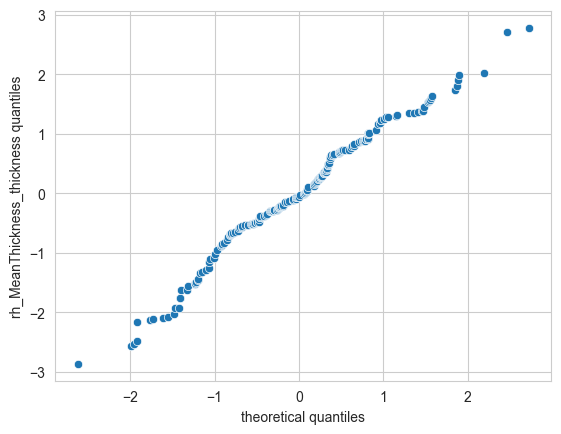

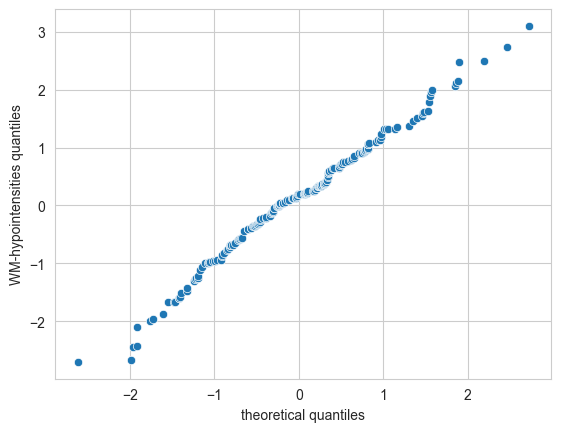

In [12]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

It may seem strange that the centiles do not match the plotted data, but that is because the centiles are calculated for a single batch effect, and it is superimposed on the full dataset. The blue markers correspond to the data for which the centiles are calculated. 

Sampling: [y_pred]


Process: 8071 - Computing centiles for 2 response variables.
Process: 8071 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


Process: 8071 - Computing centiles for rh_MeanThickness_thickness.


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


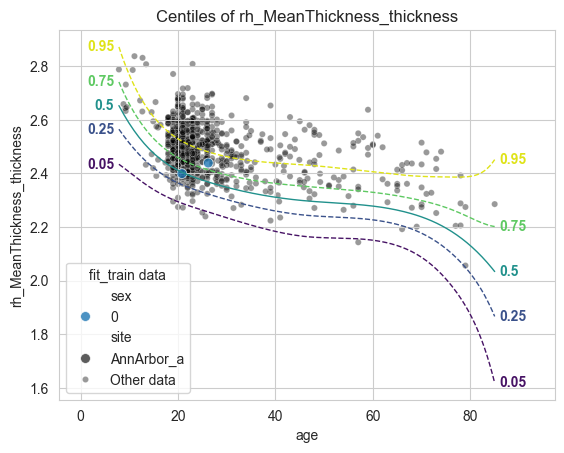

/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


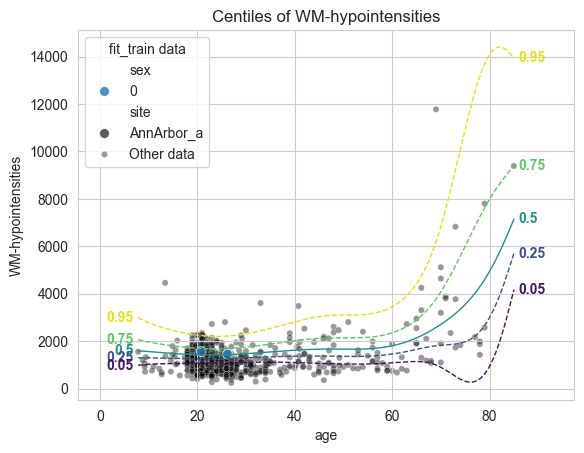

In [13]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
    show_other_data=True,
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Process: 8071 - Computing centiles for 2 response variables.
Process: 8071 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]
Sampling: [y_pred]


Process: 8071 - Computing centiles for rh_MeanThickness_thickness.


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


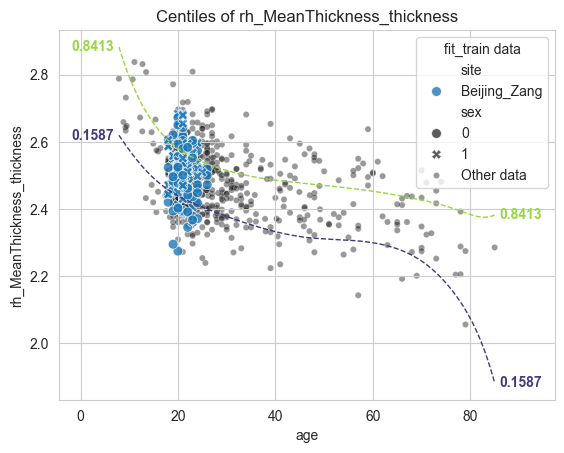

/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


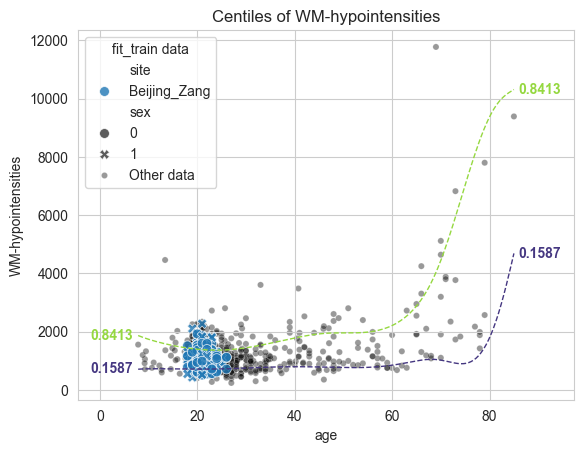

In [14]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
    show_other_data=True,
)

## Transfer

If we transfer to new dataset, we use the samples from the posterior to derive priors for a new model. That new model is then fitted on the new dataset. Our new model will not work on the old data. To give some extra control over the fit, we let the `freedom` parameter control the variance of the derived factorized posterior. Here we set it to something small (1e-4) to create a spike prior on the model parameters, to ensure that we do not 'forget' about what we learned from the original data. If we have a very large new dataset, we can set the freedom parameter to something bigger. 

In [5]:
save_dir = "resources/hbr/save_dir"
model = load_normative_model(save_dir)

transfered_model = model.transfer_predict(transfer_train, transfer_test, freedom=1e-10, nuts_sampler="nutpie")

Process: 8496 - Configuration of normative model is valid.
Process: 8496 - Configuration of normative model is valid.
Process: 8496 - Configuration of normative model is valid.
Process: 8496 - Transferring models on 2 response variables.
Process: 8496 - Transferring model for rh_MeanThickness_thickness.


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.01,1023
,2000,0,0.01,1023
,2000,0,0.00,1023
,2000,0,0.01,511


Process: 8496 - Transferring model for WM-hypointensities.


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.02,511
,2000,0,0.02,255
,2000,0,0.02,511
,2000,0,0.01,1023


Process: 8496 - Saving model to resources/hbr/save_dir_transfer.


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/output.py:148: UserWarning: Process: 8496 - The dataset transfer_test has unknown batch effects: {'sex': [], 'site': []}
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
Sampling: [y_pred]


Output()

Process: 8496 - Making predictions on 2 response variables.
Process: 8496 - Making predictions on rh_MeanThickness_thickness.


Sampling: [y_pred]


Output()

Process: 8496 - Making predictions on WM-hypointensities.


Process: 8496 - Computing log-probabilities for 2 response variables.
Process: 8496 - Computing log-probabilities for rh_MeanThickness_thickness.
Process: 8496 - Computing log-probabilities for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Computing z-scores for 2 response variables.
Process: 8496 - Computing z-scores for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing z-scores for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Computing centiles for 2 response variables.
Process: 8496 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Saving results to resources/hbr/save_dir_transfer.
Process: 8496 - Computing centiles for 2 response variables.
Process: 8496 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing centiles for WM-hypointensities.


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)
/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


In [7]:
transfered_model.predict(transfer_test)

/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/output.py:148: UserWarning: Process: 8496 - The dataset transfer_test has unknown batch effects: {'sex': [], 'site': []}
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
Sampling: [y_pred]


Output()

Process: 8496 - Making predictions on 2 response variables.
Process: 8496 - Making predictions on rh_MeanThickness_thickness.


Sampling: [y_pred]


Output()

Process: 8496 - Making predictions on WM-hypointensities.


Process: 8496 - Computing log-probabilities for 2 response variables.
Process: 8496 - Computing log-probabilities for rh_MeanThickness_thickness.
Process: 8496 - Computing log-probabilities for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Computing z-scores for 2 response variables.
Process: 8496 - Computing z-scores for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing z-scores for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Computing centiles for 2 response variables.
Process: 8496 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Saving results to resources/hbr/save_dir_transfer.
Process: 8496 - Computing centiles for 2 response variables.
Process: 8496 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing centiles for WM-hypointensities.


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)
/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


<xarray.NormData> Size: 13kB
Dimensions:            (datapoints: 30, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2, basis_functions: 7, cdf: 5,
                        measure: 8)
Coordinates:
  * datapoints         (datapoints) int64 240B 951 953 915 943 ... 973 908 976
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * basis_functions    (basis_functions) <U13 364B 'age_bspline_0' ... 'age_b...
  * cdf                (cdf) float64 40B 0.05 0.25 0.5 0.75 0.95
  * measure            (measure) <U8 256B 'MSLL' 'NLL' ... 'SMSE' 'ShapiroW'
Data variables:
    X                  (datapoints, covariates) float64 240B 21.0 22.0 ... 21.0
    y                  (datapoints, response_vars) float64 480B 2.482 ... 646.6
    batch_effects      (datapoints, batch_effect_dims) <U11 3kB '0' ... 'Oulu'
    scaled_X           (datapoints, covariates) float64 240B -0.5173 ... -0.5173
    scaled_y           (datapoints, response_vars) float64 480B -0.01111 ... ...
    Phi                (datapoints, basis_functions) float64 2kB 0.4009 ... 0.0
    logp               (datapoints, response_vars) float64 480B -0.9571 ... -...
    zscores            (datapoints, response_vars) float64 480B -0.9785 ... -...
    scaled_centiles    (cdf, datapoints, response_vars) float64 2kB -0.448 .....
    centiles           (cdf, datapoints, response_vars) float64 2kB 2.438 ......
    Yhat               (datapoints, response_vars) float64 480B 2.543 ... 1.1...
    measures           (response_vars, measure) float64 128B -1.972 ... 0.957
Attributes:
    name:                  transfer_test
    unique_batch_effects:  {'sex': ['0', '1'], 'site': ['Milwaukee_b', 'Oulu']}
    batch_effects_counts:  {'sex': {'0': 96, '1': 52}, 'site': {'Milwaukee_b'...

We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path.

### Extend

Extending a model on new data amounts to generating synthetic data according to the learned distribution, merging that with the new data, and fitting a new model on that merged dataset. This enables true federated learning, because the original data does not need to be shipped with the model to extend it to a new dataset. 

Because this is an extended model, we can make predictions on all sites, even those that were only present in the original data. 

In [8]:
save_dir = "resources/hbr/save_dir"

model = load_normative_model(save_dir)

extended_model = model.extend_predict(transfer_train, transfer_test)

Process: 8496 - Configuration of normative model is valid.
Process: 8496 - Configuration of normative model is valid.


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Process: 8496 - Fitting and predicting 2 response variables.
Process: 8496 - Fitting and predicting model for rh_MeanThickness_thickness.


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.02,1023
,2000,0,0.03,767
,2000,0,0.01,511
,2000,1,0.01,767


Sampling: [y_pred]


Output()

Process: 8496 - Fitting and predicting model for WM-hypointensities.


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.00,1023
,2000,0,0.01,1023
,2000,0,0.01,511
,2000,0,0.01,1023


Sampling: [y_pred]


Output()

Process: 8496 - Saving model to resources/hbr/save_dir_extend.
Process: 8496 - Computing log-probabilities for 2 response variables.
Process: 8496 - Computing log-probabilities for rh_MeanThickness_thickness.
Process: 8496 - Computing log-probabilities for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Computing z-scores for 2 response variables.
Process: 8496 - Computing z-scores for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing z-scores for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Computing centiles for 2 response variables.
Process: 8496 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Saving results to resources/hbr/save_dir_extend.
Process: 8496 - Computing centiles for 2 response variables.
Process: 8496 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing centiles for WM-hypointensities.


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)
/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


In [9]:
extended_model.predict(test)

/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/output.py:148: UserWarning: Process: 8496 - The dataset fit_test has unknown batch effects: {'sex': [], 'site': []}
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
Sampling: [y_pred]


Output()

Process: 8496 - Making predictions on 2 response variables.
Process: 8496 - Making predictions on rh_MeanThickness_thickness.


Sampling: [y_pred]


Output()

Process: 8496 - Making predictions on WM-hypointensities.


Process: 8496 - Computing log-probabilities for 2 response variables.
Process: 8496 - Computing log-probabilities for rh_MeanThickness_thickness.
Process: 8496 - Computing log-probabilities for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Computing z-scores for 2 response variables.
Process: 8496 - Computing z-scores for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing z-scores for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Computing centiles for 2 response variables.
Process: 8496 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


Process: 8496 - Saving results to resources/hbr/save_dir_extend.
Process: 8496 - Computing centiles for 2 response variables.
Process: 8496 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 8496 - Computing centiles for WM-hypointensities.


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)
/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"] * len(non_be_df)


<xarray.NormData> Size: 86kB
Dimensions:            (datapoints: 186, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2, basis_functions: 7, cdf: 5,
                        measure: 8)
Coordinates:
  * datapoints         (datapoints) int64 1kB 515 441 1029 64 ... 640 648 635
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * basis_functions    (basis_functions) <U13 364B 'age_bspline_0' ... 'age_b...
  * cdf                (cdf) float64 40B 0.05 0.25 0.5 0.75 0.95
  * measure            (measure) <U8 256B 'MSLL' 'NLL' ... 'SMSE' 'ShapiroW'
Data variables:
    X                  (datapoints, covariates) float64 1kB 18.0 20.0 ... 20.0
    y                  (datapoints, response_vars) float64 3kB 2.456 ... 460.3
    batch_effects      (datapoints, batch_effect_dims) <U17 25kB '0' ... 'ICBM'
    scaled_X           (datapoints, covariates) float64 1kB -1.185 ... -1.096
    scaled_y           (datapoints, response_vars) float64 3kB 0.1906 ... -0....
    Phi                (datapoints, basis_functions) float64 10kB 0.04496 ......
    logp               (datapoints, response_vars) float64 3kB -0.4322 ... -0...
    zscores            (datapoints, response_vars) float64 3kB -0.7906 ... -1...
    scaled_centiles    (cdf, datapoints, response_vars) float64 15kB -0.2152 ...
    centiles           (cdf, datapoints, response_vars) float64 15kB 2.39 ......
    Yhat               (datapoints, response_vars) float64 3kB 2.511 ... 894.2
    measures           (response_vars, measure) float64 128B -1.645 ... 0.9945
Attributes:
    name:                  fit_test
    unique_batch_effects:  {'sex': ['0', '1'], 'site': ['AnnArbor_a', 'AnnArb...
    batch_effects_counts:  {'sex': {'0': 493, '1': 437}, 'site': {'AnnArbor_a...

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset
- Extend the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!